# Turbulence diagnostics
After completing the post-processing, we can now move on to looking at some turbulence diagnostics. 
Based on the generated half-hourly output of the first notebook ([01_post-processing.ipynb](https://github.com/noctiluc3nt/ec_analyze/blob/main/notebooks/01_post-processing.ipynb)) some standard turbulence quantities, i.e. stability parameter, friction velocity, TKE, turbulence intensity are calculated and plotted, which allow to study flow properties.

In [2]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE)
library(Reddy)
library(latex2exp)
kap=function() return(0.4)

Installing package into ‘/home/lauracma/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [3]:
#read in processed example data
dat=readRDS("../data/ec-data_30min_processed/processed_data_example.rds")

## Standard turbulence diagnostics and simple timeseries plots
Here, some functions from the Reddy package are used to calculate turbulent kinetic energy $TKE$, velocity scale of TKE $V_{TKE}$, horizontal turbulence intensity $TI$, vertical turbulence intensity $I_w$, friction velocity $u_*$, Obukhov length $L$, stability parameter $\zeta$ and directional shear angle and plot their timeseries for the previously post-processed example data. <br>


- **Turbulence intensity** (`calc_ti` and `calc_iw`): Turbulence intensity generally refers to the standard deviation, e.g., $\sigma_u, \sigma_v, \sigma_w, \sigma_T$, and thus describes the mean fluctuation intensity. The horizontal turbulence intensity TI (`calc_ti`) and the vertical turbulence intensity $I_w$ (`calc_iw`) are calculated by normalizing the respective standard deviations with the mean wind speed $\overline{u}$:
$$TI = \frac{\sqrt{\sigma_u^2+\sigma_v^2}}{\overline{u}} ,\quad\quad I_w= \frac{\sigma_w}{\overline{u}} $$
- **Turbulent kinetic energy TKE** (`calc_tke`): TKE describes the mean kinetic energy that the eddies contain and is calculated by
 $$ TKE = 0.5 (\sigma_u^2 + \sigma_v^2 + \sigma_w^2) =0.5 (\overline{u'^2} + \overline{v'^2} + \overline{w'^2}  ).$$
 From the TKE, a velocity scale can easily be derived $V_{TKE} = \sqrt{TKE}$ (`calc_vtke`).
- **Friction velocity** $u_*$ (`calc_ustar`): The friction velocity describes the effect of friction in form of a velocity scale
$$ u_* = \sqrt[4]{\overline{u'v'}^2+\overline{v'w'}^2}.$$
- **Obukhov length** $L$ (`calc_L`): The Obukhov length is a length scale that describes the effect of buoyancy 
$$ L = -\frac{u_*^3 \overline{T_v}}{\kappa \,g\,\overline{w'T'}}, $$
which is central in Monin-Obukhov similarity theory (MOST) to derive dimensionless scaling parameter, like the stability parameter $\zeta$.
The fluxes used in the calculation are either the surface fluxes for global scaling or the fluxes at the measurement height for local scaling.
- **Stability parameter** $\zeta$ (`calc_zeta`): The stability parameter is the ratio of Obukhov length and measurement height and thus a dimensionless measure for stability
$$ \zeta = \frac{z}{L}.$$

In [4]:
#calculation of some useful turbulence diagnostics
dat$tke=calc_tke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$vtke=calc_vtke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$ti=calc_ti(dat$u_sd,dat$v_sd,dat$ws_mean)
dat$iw=calc_iw(dat$w_sd,dat$ws_mean)
dat$ustar=calc_ustar(dat$cov_uw,dat$cov_vw)
dat$L=calc_L(dat$ustar,dat$T_mean,dat$cov_wT)
dat$zeta=calc_zeta(4.4,dat$L)
dat$alpha_uw=calc_dshear(dat$cov_uw,dat$cov_vw)

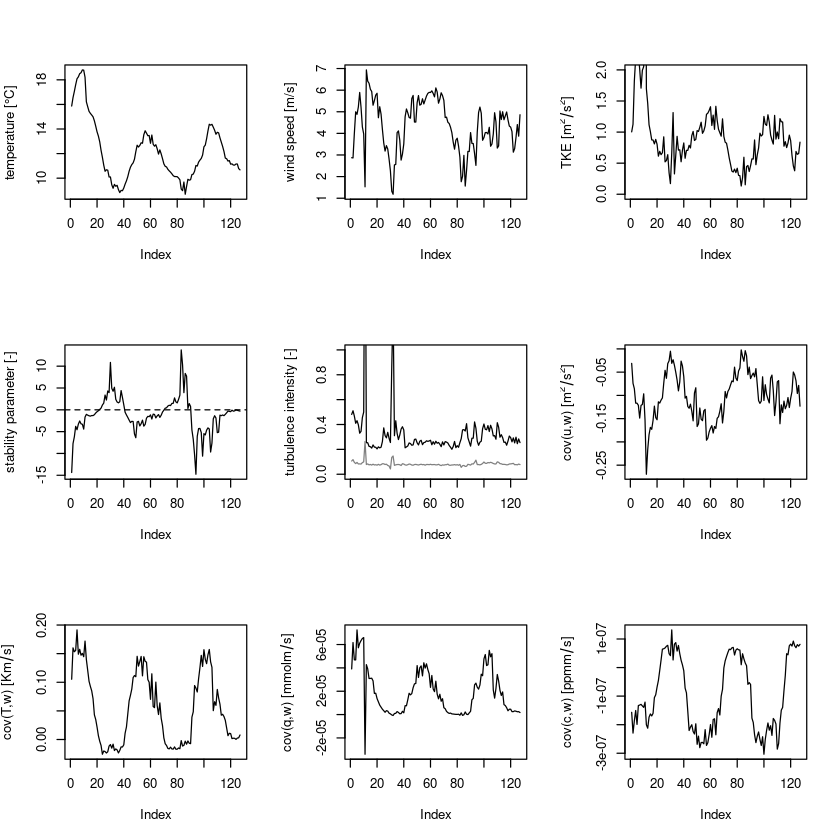

In [22]:
#basic timeseries plots
par(mfrow=c(3,3))
plot(dat$T_mean,type="l",ylab="temperature [°C]")
plot(dat$ws_mean,type="l",ylab="wind speed [m/s]")
plot(dat$tke,type="l",ylab=TeX("TKE [$m^2/s^2$]"),ylim=c(0,2))
plot(dat$zeta,type="l",ylab="stability parameter [-]")
abline(h=0,lty=2)
plot(dat$ti,type="l",ylab="turbulence intensity [-]",ylim=c(0,1))
points(dat$iw,type="l",col="gray50")
plot(dat$cov_uw,type="l",ylab=TeX("cov(u,w) [$m^2/s^2$]"))
plot(dat$cov_wT,type="l",ylab=TeX("cov(T,w) [$K m/s$]"))
plot(dat$cov_h2ow,type="l",ylab=TeX("cov(q,w) [$mmol m/s$]"))
plot(dat$cov_co2w,type="l",ylab=TeX("cov(c,w) [$ppm m/s$]"))

## Stability dependence
It is often interesting to investigate the stability dependence of turbulence characteristics, e.g. since Monin-Obukhov similarity theory (MOST) predict all dimensionless turbulence characteristics based on the dimensionless stability parameter. A simple way is to plot stability versus a turbulence characteristic and bin the data based on stability intervals. For this the function `binning` can be used, which bins one variable based on another for predefined bins, as exemplified below for the dependence of the sensible heat flux on the stability parameter. The output contains mean, median, 25% and 75% quartile per discrete bin as dataframe. The used variables and the bins can be customized. Such type of analysis is usually applied to longer timeseries. 

122.045246,116.804837,109.052920,129.797163
120.620398,125.471467,75.448402,167.986972
17.306097,12.061651,5.647776,24.415438
1.823135,1.864732,1.093005,2.574063
NA,NA,NA,NA
-3.564331,-3.564331,-3.564331,-3.564331
-11.192381,-12.213284,-13.937180,-8.561890
-18.102981,-19.201199,-22.358905,-14.674265
-8.655841,-10.389901,-11.853905,-6.324807


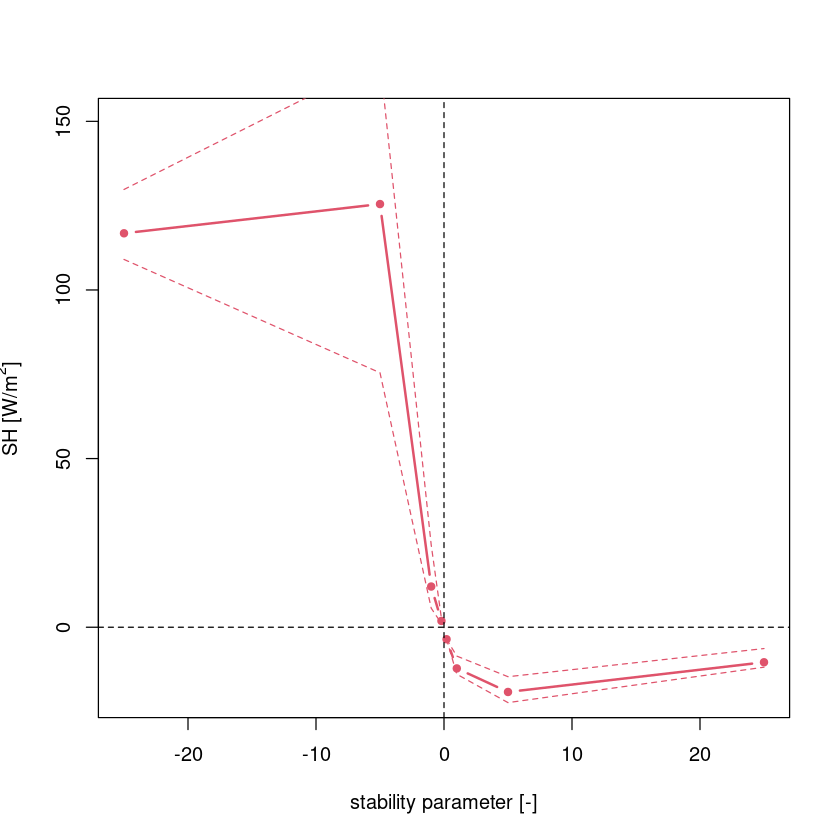

In [26]:
zeta_bins=c(-10^(2:-2),10^(-2:2))
sh_binned=binning(dat$sh,dat$zeta,zeta_bins)
sh_binned #look at output
xbins=c(-5^(2:-1),0,5^(-1:2))
plot(xbins,sh_binned[,2],type="b",ylim=c(-20,150),lwd=2,col=2,pch=20,xlab="stability parameter [-]",ylab=TeX("SH [W/m$^2$]"))
points(xbins,sh_binned[,3],type="l",lty=2,col=2)
points(xbins,sh_binned[,4],type="l",lty=2,col=2)
#polygon(c(xbins,rev(xbins)),c(sh_binned[,3],rev(sh_binned[,4])),lty=0,col=rgb(0.8,0,0,0.2) )
abline(h=0,lty=2)
abline(v=0,lty=2)

Based on our short example data, we can already see that the sensible heat flux is positive under unstable conditions and negative under stable conditions. This can also been seen directly from the definition of $\zeta$ (and $L$ therein). Such type of analysis can be extended to different quantities and binning based on other important scales, e.g. friction velocity. <!-- mention some example studies here-->

## Turbulence regimes
The above shown example for stability dependence can be extended to arbitrary variables and is used to characterize different turbulence regimes. 
To diagnose different turbulence regimes, scatter plots of different turbulence diagnostics can be used. Here are some examples plotting wind speed vs TKE or stability parameter vs TKE (see e.g., Sun et al., 2012). For example, @Sun2012 investigated turbulence regimes in stable boundary layers and distinguish between a weak and strong turbulence (and an intermediate regime). For this, they plot wind speed versus TKE or $\sigma_w$ and find two different slopes corresponding to different turbulence generation mechanism (local instability versus bulk shear) -- this model is now commonly referred to as "Hockey-stick model" (@Sun2012, therein Fig. 2). However, this schematic is very simplified and especially at sites in complex terrain versatile factors (e.g., the footprint) modify it.

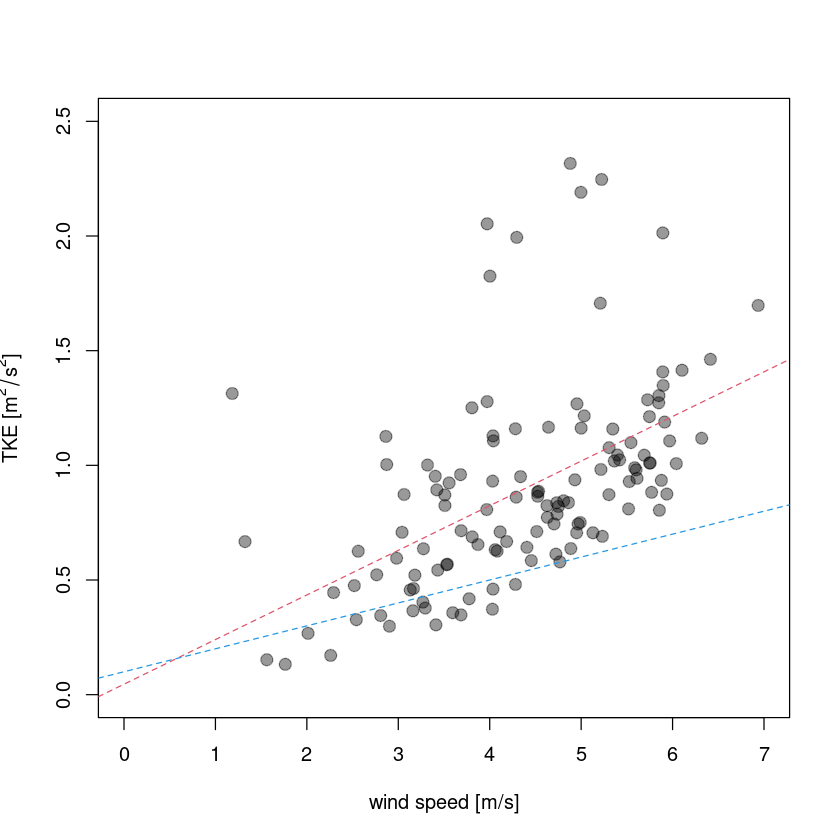

In [19]:
#some basic plots
plot(dat$ws_mean,dat$tke,xlim=c(0,7),ylim=c(0,2.5),xlab="wind speed [m/s]",ylab=TeX("TKE [$m^2/s^2$]"),cex=2,pch=20,col=rgb(0,0,0,0.4))
cond=(dat$ws_mean>4)
fit=lm(dat$tke[cond]~dat$ws_mean[cond])
abline(fit,col=2,lty=2)
abline(0.1,0.1,col=4,lty=2)

## Literature
- Sun, J., Mahrt, L., Banta, R. M., and Pichugina, Y. L. (2012). Turbulence Regimes and Turbulence Intermittency in the Stable Boundary Layer during CASES-99. J Atmos Sci, 69:338–351.